# DSL Project 2020: classification on tweet sentiment

| Student Name | Student Surname | ID |
| --- | --- | --- |
|Pouya  |Rivandi  | **299984** |
|Matteo  |Merlo  | **287576** |

### Import Libraries

In [19]:
# Numeric
import numpy as np
import pandas as pd

# Tools
import os, sys
import re
import string
import csv
import string
import datetime
from datetime import datetime

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# Flags
flag_tuning = True
flag_pipeline_model_selection = False

## Data Exploration

The dataset chosen for this text classification project contains tweets with a relative sentiment: positive or negative.

The dataset is composed of 224994 labelled tweets and for each tweet there are also some informations such as user that published it, the tweet identifier and the date.

The classes are:

* ”1” if the tweet shows a positive sentiment.
* ”0” if the tweet shows a negative sentiment.

The distribution of the tweets between the two classes is quite balanced: there are 170506 tweets classified as 1 and 124488 tweets classified as 0.

Analysing the dataset, it pops also out that there are a few tweets that are duplicates, around 270 tweets.

The quality of the tweets is also quite low: there are many slang or wrong written, emoticon and web-links, most of them are trimmed and they are also hardly classifiable even for a human:

`@kristianinicole I left it @ home  http://myloc.me/21cN`<br/>
`LOL You just have to love the irony @lastfm  http://is.gd/LsmE (via @igorajdisek)`<br/>
`@Ms_lonelystar Thank you honey  Hope you're having a great week so far  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx`<br/>

Due to the previously explained problems about the tweets, in the following steps (especially in the Preprocessing one) we will see that a non-invasive text cleaning approach pays more for this text classification task, since in some tweets there are so few features that even the user mentioned (’@’) could be useful to classify a tweet.

In [20]:
dir_path = "DSL2122_january_dataset/"
dev_dataset = pd.read_csv(dir_path + "development.csv",  infer_datetime_format=True, parse_dates=["date"])


print(dev_dataset.iloc[:,0].size)
dev_dataset.head()

/home/matteo/.local/lib/python3.8/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


224994


,sentiment,ids,date,flag,user,text
0,1,1833972543,2009-05-18 01:08:27,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,2009-05-31 06:23:17,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,2009-06-01 11:52:54,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,2009-05-17 02:45:34,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,2009-06-02 00:08:07,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [21]:
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sentiment  224994 non-null  int64         
 1   ids        224994 non-null  int64         
 2   date       224994 non-null  datetime64[ns]
 3   flag       224994 non-null  object        
 4   user       224994 non-null  object        
 5   text       224994 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.3+ MB


In [22]:
print(f"Development dataset size: {dev_dataset['text'].size}")

Development dataset size: 224994


In [23]:
# creation column of hour, weekday, month from date
dev_dataset["hour"] = dev_dataset["date"].apply(lambda x: x.hour)
dev_dataset["weekday"] = dev_dataset["date"].apply(lambda x: x.weekday())
dev_dataset["month"] = dev_dataset["date"].apply(lambda x: x.month)
dev_dataset["day"] = dev_dataset["date"].apply(lambda x: x.day)


dev_dataset.head()

,sentiment,ids,date,flag,user,text,hour,weekday,month,day
0,1,1833972543,2009-05-18 01:08:27,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",1,0,5,18
1,1,1980318193,2009-05-31 06:23:17,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,6,6,5,31
2,1,1994409198,2009-06-01 11:52:54,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone,11,0,6,1
3,0,1824749377,2009-05-17 02:45:34,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...,2,6,5,17
4,0,2001199113,2009-06-02 00:08:07,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,0,1,6,2


/tmp/ipykernel_322534/2996525026.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(["void", "Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"])


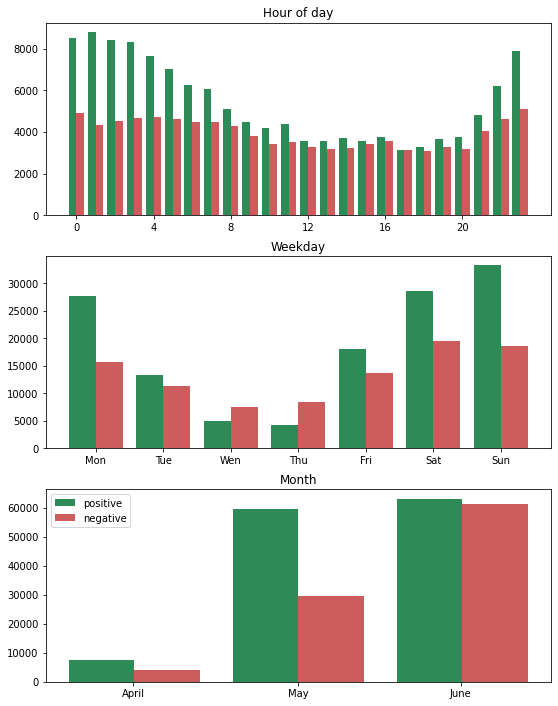

In [24]:
# plt.figure(figsize=(6,12))
fig, axs = plt.subplots(3, figsize=(8,10))

fig.tight_layout(pad=2)
axs[0].hist((dev_dataset[dev_dataset['sentiment'] == 1]["hour"], dev_dataset[dev_dataset['sentiment'] == 0]["hour"]),  bins=np.arange(25)-0.5, label=['positive', 'negative'], color=['seagreen', 'indianred'])
axs[1].hist((dev_dataset[dev_dataset['sentiment'] == 1]["weekday"], dev_dataset[dev_dataset['sentiment'] == 0]["weekday"]),  bins=np.arange(8)-0.5, label=['positive', 'negative'], color=['seagreen', 'indianred'])
axs[2].hist((dev_dataset[dev_dataset['sentiment'] == 1]["month"], dev_dataset[dev_dataset['sentiment'] == 0]["month"]),  bins=3, label=['positive', 'negative'], color=['seagreen', 'indianred'])
# np.arange(4,8)-0.5
axs[0].set_title("Hour of day")
axs[1].set_title("Weekday")
axs[2].set_title("Month")

axs[0].set_xticks(np.arange(0, 23, 4))

axs[1].set_xticklabels(["void", "Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"])

axs[2].set_xticks([4.33,5,5.66])
axs[2].set_xticklabels(["April", "May", "June"])
axs[2].legend(loc='upper left')    

plt.savefig("dateDistributionHour.svg")

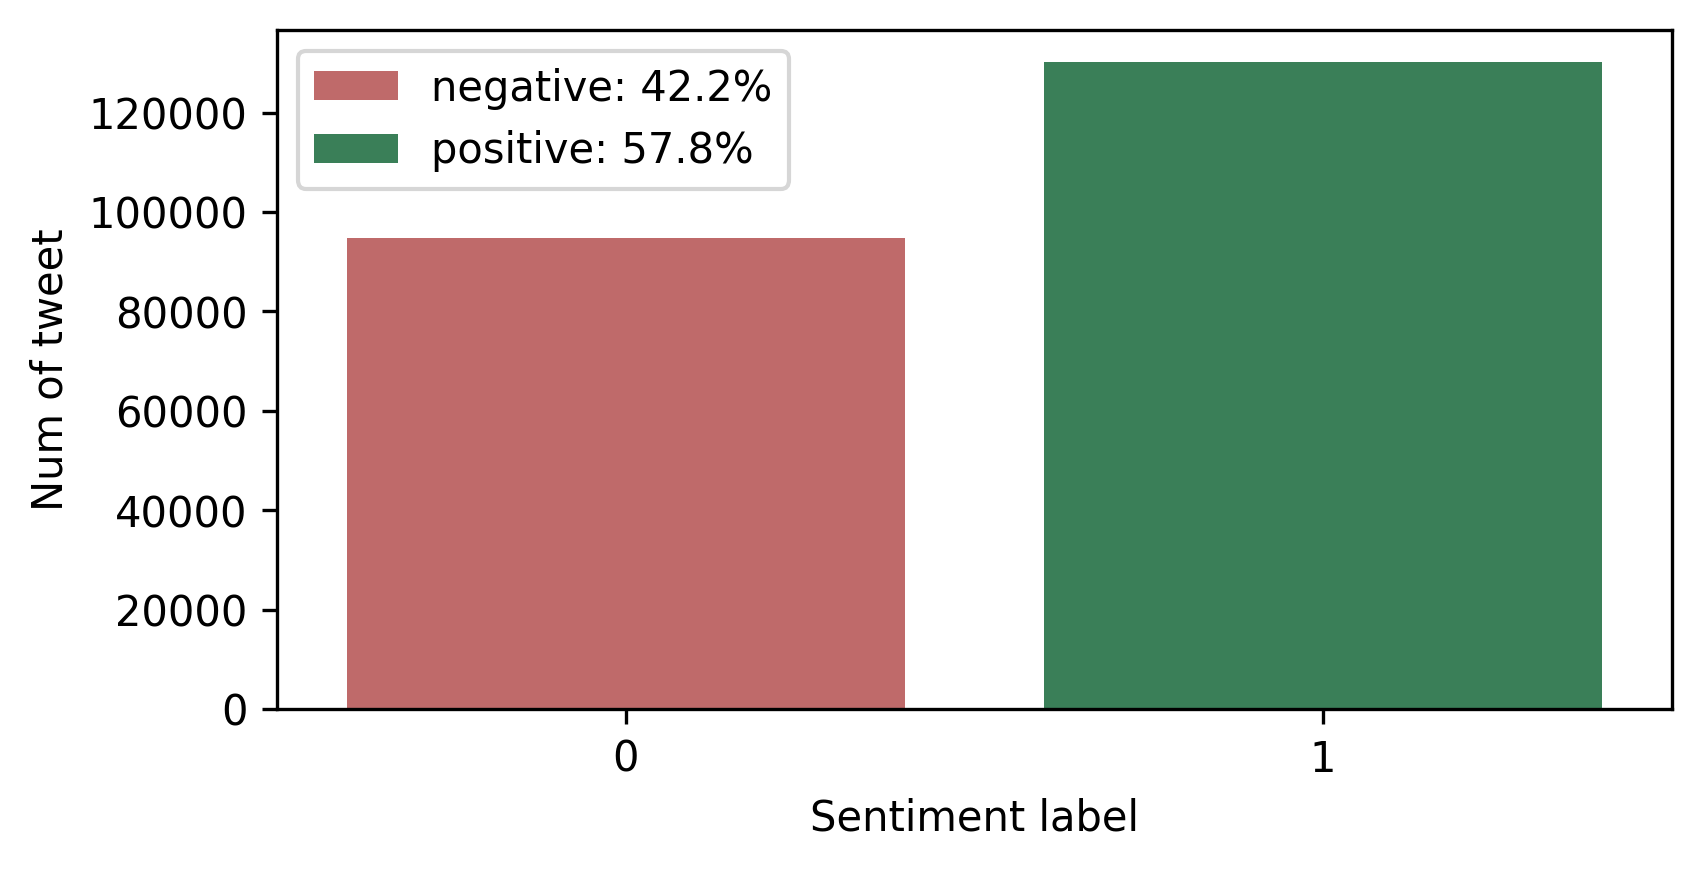

In [25]:
# compute distribution percentages
pos_perc = 100 * dev_dataset[dev_dataset['sentiment'] == 1].size / dev_dataset.size
neg_perc = 100 - pos_perc

fig, ax = plt.subplots(dpi=300, figsize=(6,3))
ax = sns.countplot(x = 'sentiment', data = dev_dataset, #color=['red', 'green'])
              palette=sns.color_palette(['indianred', 'seagreen'], 2))
ax.set_ylabel('Num of tweet')
ax.set_xlabel('Sentiment label')
# ax.set_title('Distribution of sentiment')
ax.legend(handles=ax.patches, labels=(f'negative: {neg_perc:.1f}%', f'positive: {pos_perc:.1f}%'))
plt.savefig('DistributionOfSentiment.svg', bbox_inches="tight")
plt.show()

In [26]:
ds = dev_dataset.copy()
# how many tweet ids are duplicates? around 270
ds.drop_duplicates(['ids'],inplace=True)
print(ds.iloc[:,0].size)

224716


In [27]:
ds = dev_dataset.copy()
# how many user are there? around 10000
ds.drop_duplicates(['user'],inplace=True)
print(ds.iloc[:,0].size)

10647


In [28]:
ds = dev_dataset.copy()
# how many copies of tweet text are there? around 1800
ds.drop_duplicates(['text'],inplace=True)
print( dev_dataset.iloc[:,0].size - ds.iloc[:,0].size )

1888


In [29]:
# drop useless column and duplicates
dev_dataset.drop_duplicates(['text'],keep='first',inplace=True)

df_done = dev_dataset.drop(columns=["flag", "ids", "date"])

df_done.head()

,sentiment,user,text,hour,weekday,month,day
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",1,0,5,18
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,6,6,5,31
2,1,yaseminx3,@PleaseBeMine Something for your iphone,11,0,6,1
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,2,6,5,17
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,0,1,6,2


In [30]:
df_done.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223106 entries, 0 to 224993
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  223106 non-null  int64 
 1   user       223106 non-null  object
 2   text       223106 non-null  object
 3   hour       223106 non-null  int64 
 4   weekday    223106 non-null  int64 
 5   month      223106 non-null  int64 
 6   day        223106 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 13.6+ MB


##  Text preprocessing

The full preprocessing pipeline scheduled for this project is the following: 

* Cut mentions (’@’) to user
* Cut websites links
* Translate short form of verbs or slang version of the same
* Replace special character and special short word or slang
* Replace 3 or more same consecutive letter with only 2 letter

Although, some preprocess operations don't improve overall accuracy and so we decided to remove them. In particular we don't use:

* Stemming and Lemmatization of the text
* Remove stopwords since many relevant word are considered stopword
* Remove unicode error from translation of HTML such as $&quot;$ , $&lt;$ and $&gt;$ 

We have removed the repeating characters from the words along with removing the URLs as they do not have any significant importance.
To avoid the increase of dispersion of feature importance, many slang word are translated to the base form.

Future develpment: remove and translate emoticon to word: instead of being discarded as punctation, emoticon could become a feature.

In [31]:
def preprocess_text_tweet_for_tfidfVect( tweet ):
    
    tweet = tweet.lower()
    tweet = tweet.replace("@", "") # remove @ before user name
    tweet = tweet.replace("#", "").replace('&', " ") # remove # of hashtag and &    
    
    tweet = re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet) # remove links
#     tweet = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)'," ",tweet) # remove links other version
    tweet = re.sub(r"[^\w\d'\s]+"," ",tweet) # remove punctuation except for ' 
    
    # translate short form of verbs and slang
    tweet = tweet.replace("'ve", " have ").replace(" ive ", " i have ").replace(" hav ", " have ").replace(" havent ", " have not ")
    tweet = tweet.replace(" cant ", "can not ").replace("can't", "can not ").replace("'d", " would ").replace("couldnt", " could not ")
    tweet = tweet.replace("'ll", " will ").replace("won't", " will not ")
    tweet = tweet.replace("it's", "it is ").replace("i'm", " i am ").replace("im "," i am ").replace("'re", " are")
    tweet = tweet.replace("he's", "he is ").replace("she's", "she is ").replace("there's ", "there is ")
    tweet = tweet.replace("n't", " not ").replace("n t ", " not ").replace("dont ", " not ").replace("didnt ", " not ")
    tweet = tweet.replace("what's ", "what is ").replace("how's ", " how is ").replace("where's ", "where is ").replace("here's ", "here is ")
    tweet = tweet.replace("'s ", " own ")


#     replace special character and special short word
    tweet = tweet.replace("%", " percent ").replace("$", " dollar ").replace("_", " ").replace("-", " ")
    tweet = tweet.replace(" ye ", " you ").replace(" yeh ", " yeah ").replace(" yt ", " youtube ").replace(" ty ", " thank ")
    tweet = tweet.replace("in'", "ing ").replace(" u ", " you ").replace(" r ", " your ").replace(" ur ", " your ").replace(" 2 ", " to ").replace(" 4 ", " for ")
    tweet = tweet.replace("every1 ", " everyone ").replace(" n ", " and ").replace("yrs", " years ").replace("2day", " today ")
    tweet = tweet.replace(" wth ", " with ").replace("jst", " just ").replace(" 4got ", " forget ")
    
#     tweet = tweet.replace('btw', ' by the way ').replace(" thats ", " that is ").replace(" idk ", " i do not know ")
    
    # remove meaningless word from unicode error (probably from HTML translation error)
#     tweet = tweet.replace(' amp '," ").replace(' gt '," ").replace(' quot ', " ").replace(' lt '," ") #in some way important do not remove
    
    tweet = re.sub(r'[^A-Za-z0-9]+'," ",tweet) # remove all non alphanumeric char
    tweet = re.sub(r' +'," ",tweet)# remove multiple space
    tweet = re.sub(r'[^\x00-\x7F]+',' ',tweet) # Removing non ASCII character
    tweet = re.sub(r"(.)\1+", r"\1\1", tweet) # remove multiple repeated character
    
    return tweet

In [32]:
import time
t = time.time()

# Preprocessing
df_done["text"] = df_done["text"].apply(lambda tweet: preprocess_text_tweet_for_tfidfVect(tweet))

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds') 

df_done["text"].to_csv("developmentElaborated.csv")
df_done.head()

Text Preprocessing complete.
Time Taken: 6 seconds


,sentiment,user,text,hour,weekday,month,day
0,1,Killandra,missbianca76 yes talking helps a lot going thr...,1,0,5,18
1,1,IMlisacowan,sunshine livingg itt imma lie on the grass lis...,6,6,5,31
2,1,yaseminx3,pleasebemine something for your iphone,11,0,6,1
3,0,no_surprises,gabrielsaporta could not get in to the after p...,2,6,5,17
4,0,Rhi_ShortStack,bradiewebbstack aww is andy being mean again n...,0,1,6,2


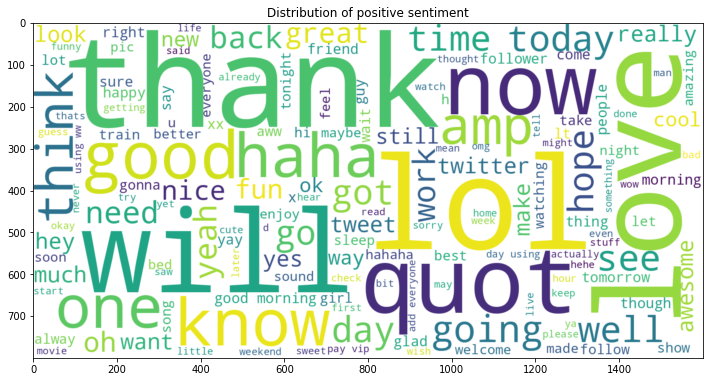

In [18]:
plt.figure(figsize = (12,12)) 
wc = WordCloud(max_words = 150 , width = 1600 , height = 800, background_color="white").generate(" ".join(df_done[df_done.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Distribution of positive sentiment')
plt.savefig('WordCloudPositive.svg', bbox_inches="tight")

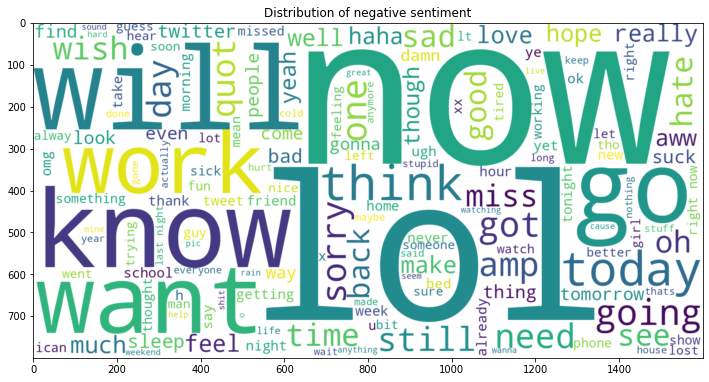

In [16]:
plt.figure(figsize = (12,12)) 
wc = WordCloud(max_words = 150 , width = 1600 , height = 800, background_color="white").generate(" ".join(df_done[df_done.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Distribution of negative sentiment')
plt.savefig('WordCloudNegative.svg', bbox_inches="tight")

## Algorithm Choice

Initially, we make an inspection using 4 different classifiers:

* MultinomialNB
* Random Forest Classifier
* Logistic Regressor
* LinearSVC 

The test set was made up of the 20% of the development set.

![title](ModelsMeanAccuracy.svg)

| Model | Mean Accuracy | Standard Deviation |
| --- | --- | --- |
| LinearSVC | 0.847 | 0.001212 |
| LogisticRegression | 0.837 | 0.001729 |
| MultinomialNB | 0.740 | 0.001889 |
| RandomForest | 0.786 | 0.003056 |

Before doing hyperparameters tuning, the MultinomialNB reached 74,05% of accuracy. After this first attempt, we have compared it to the other classifiers and we have decided to not tune it because it wasn’t promising and the resulted training was quite long to do.

After the MultinomialNB, I tried the RandomForestClassifier, which not performed very well on evaluation set and led to an accuracy of just 78.6%. So, I decided to do discard this method.

In addition, I tried to use the LogisticRegressor; I thought that this regressor could be a good one for this project because of its capability on modelling binary classification problems. Using the LogisticRegressor the accuracy reach a good initial 83.71%.
By the way, the improvements achieved by means of the hyperparameters tuning on LogisticRegressor were inexistent on evaluation set, and the final accuracy remained almost the same, with 84.7%.

Finally, I decided to try the LinearSVC classifiers, since it is based on Support Vector machine. It is modelling specifically for binary classification problems. The LinearSVC achieved initially a promising accuracy of 84.71%. Also in this case the parameter tuning do not improve significantly the accuracy. The final accuracy achieved is 85.2%

Even if Support Vector Machine algorithm (with linear kernel) perform similarly to the Logistic Regression, I think that the first one performs better on this project because of the sensitivity to marginal values. The sigmoid function of the LogisticRegressor tends to not properly identify simil-neutral values, while the Support Vector Machine algorithm tries to construct the best widest possible separating line to split this two clusters.

All the evaluation for the accuracy were done with accuracy score, as suggested in the assignment, and all the classifiers were provided by the Scikit Learn package.



In [33]:
X = df_done.drop(columns=["sentiment"])
y = df_done["sentiment"]

X.shape, y.shape

((223106, 6), (223106,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42, shuffle=True)

In [19]:
# time to complete the search of best tecnique: around 180 min
if flag_pipeline_model_selection:   
    models = [  MultinomialNB(), #0.74
                RandomForestClassifier(n_jobs=-1), #0.78
                LogisticRegression(n_jobs=-1), # 0.837
                LinearSVC(), #0.847
             ]

    entries = []

    for i in range(len(models)):
        model_name = models[i].__class__.__name__
        pipeModel = make_pipeline(
                        make_column_transformer(
                            (TfidfVectorizer(ngram_range= (1, 3)), "text"),
                            (OneHotEncoder(handle_unknown="ignore"), ["user", "hour", "weekday", "month", "day"]),
                            remainder="passthrough",
                            n_jobs=-1
                        ),
                        models[i]
                    )

        accuracies = cross_val_score(pipeModel, X_train, y_train, scoring='f1_macro', cv=5, n_jobs=-1)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))

    cross_val_result_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    mean_accuracy = cross_val_result_df.groupby('model_name').accuracy.mean()
    std_accuracy = cross_val_result_df.groupby('model_name').accuracy.std()
    acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
              ignore_index=True)
    acc.columns = ['Mean Accuracy', 'Standard deviation']


/home/matteo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


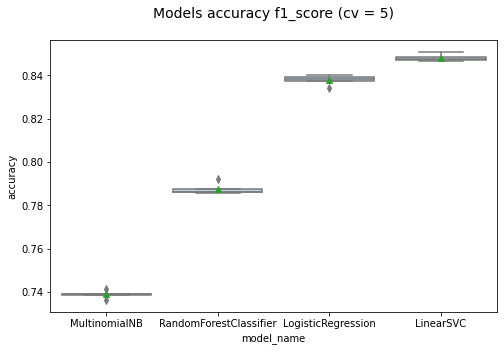

In [20]:
if flag_pipeline_model_selection:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='model_name', y='accuracy', 
                data=cross_val_result_df, 
                color='lightblue', 
                showmeans=True)
    plt.title("Models accuracy f1_score (cv = 5)\n", size=14);
    plt.savefig('ModelsMeanAccuracy.svg', bbox_inches="tight")

## Tuning hyperparameter and validation

First we try to find the best parameter for TfidfVectorizer. We decided that ngram is the most relevat parameter to tuning.

Then in order to tune properly the classifiers I tried different values of C and tol for Logistic Regressor and LinearSVC, since we thought that they are the most relevant parameter for the accuracy.

After some attempts, for the LinearSVC classifier I ended up that C = 0.4 and tol = 0.01 were the best in terms of accuracy. So, this classifier works better with a large margin around the hyperplane. The accuracy reached on evaluation set is 84.52%.

The best C value found for the Logistic Regressor is 6.5 and a tol of 0.001. The accuracy on evaluation set is 84.50%.

So, comparing the Logistic Regressor with the LinearSVC and their best C values, we can see that the LinearSVC performs slightly better.

Parameter tested:
* LinearSVC C = { 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2 }
* Logistic Regressor C = { 1.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0 }


In [21]:
# preprocessor pipeline with tfIdfVectorizer and Onehotencoding

text_features = 'text' # column passed to tfidfvectorizer
text_transformer = Pipeline( steps=[
                    ('vectorizer', TfidfVectorizer())
                         ])

encoding_features = ["user", "hour", "weekday", "month", "day"] # column for encoding
encoding_transformer = Pipeline(steps=[
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('vect', text_transformer, text_features),
                        ('cat', encoding_transformer, encoding_features)
                    ])

In [22]:
t = time.time()

#Hyperparameter tuning for TfidfVectorizer
parameters = {
    'preprocessor__vect__vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),  # unigrams or bigrams
    'preprocessor__vect__vectorizer__use_idf': (True, False),
    'preprocessor__vect__vectorizer__sublinear_tf': (True, False),
    'preprocessor__vect__vectorizer__binary': (True, False)
}

tfidfModel = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC(random_state=42, max_iter=1000) )
                      ])


grid_search = GridSearchCV(tfidfModel, parameters, cv=5,  scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Text Preprocessing complete.') # 912 seconds
print(f'Time Taken: {round(time.time()-t)} seconds') 
grid_search.cv_results_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Text Preprocessing complete.
Time Taken: 798 seconds


{'mean_fit_time': array([13.08416734, 13.44404626, 13.23426547, 11.28296676, 24.48629737,
        25.29809875, 26.73207922, 24.48092518, 43.33205156, 42.83236289,
        45.07498603, 41.06265469, 60.13214316, 60.466013  , 60.43283415,
        60.32642546, 13.42854071, 15.63076239, 12.37645183, 12.20146565,
        26.95557013, 24.92124639, 27.46573172, 23.39147696, 43.02643156,
        43.99366655, 44.99502344, 42.41890578, 60.45585928, 58.96514602,
        60.47974143, 50.16825986]),
 'std_fit_time': array([0.65085021, 0.71776375, 0.30218519, 0.99478867, 0.98308836,
        1.17713106, 1.01136675, 0.82319482, 1.61754372, 2.62619673,
        1.07100442, 2.13087276, 1.00094746, 1.33526816, 1.91685912,
        0.75416525, 1.82351339, 0.71121958, 0.64677521, 1.38830345,
        0.58764502, 0.46122376, 1.0383576 , 1.53838609, 0.76875349,
        1.23974701, 1.40382133, 1.0042605 , 1.96349187, 1.50139635,
        1.04080423, 6.93201239]),
 'mean_score_time': array([1.02530069, 0.92832794, 

In [23]:
score = f1_score(y_test, grid_search.predict(X_test), average='macro')
print(score) # 0.849
best_parameters = grid_search.best_estimator_.get_params()

print(best_parameters) # ngram = (1,3), use_idf = True(default), sublinear_tf = True, binary = False(default)

0.8501214881649999
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  sublinear_tf=True))]),
                                 'text'),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['user', 'hour', 'weekday', 'month', 'day'])])), ('classifier', LinearSVC(random_state=42))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                                  TfidfVectorizer(ngram_range

In [24]:
#Baseline LinearSVC
lsvc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC(random_state=42) )
                      ])
lsvc.fit(X_train,y_train)
linearSVCscore = f1_score(y_test, lsvc.predict(X_test), average='macro')
print(linearSVCscore) # 0.831

0.8316303947239241


In [25]:
t = time.time()

#Hyperparameter tuning for LinearSVC
parameters = {
    'classifier__C': (0.1, 0.3, 0.5, 0.7, 1, 2),
    'classifier__tol': (0.01, 0.001, 0.0001, 0.00001),
    'preprocessor__vect__vectorizer__ngram_range': ((1, 3),), 
    'preprocessor__vect__vectorizer__sublinear_tf': (True,),
}

lSVCclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC(random_state=42, max_iter=2000) )
                      ])


grid_search = GridSearchCV(lSVCclf, parameters, cv=5,  scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


print(f'Text Preprocessing complete.') # 672 seconds
print(f'Time Taken: {round(time.time()-t)} seconds') 
grid_search.cv_results_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Text Preprocessing complete.
Time Taken: 644 seconds


{'mean_fit_time': array([23.41535778, 23.75037723, 25.18800402, 24.67123022, 25.41494646,
        26.98250222, 27.66068583, 31.59394951, 27.52448597, 30.31889424,
        33.21140289, 35.47865229, 32.22279482, 33.06172843, 37.03793845,
        41.85951033, 34.28751316, 39.04807944, 44.42355156, 50.19157476,
        47.56446877, 55.74907813, 66.74098048, 65.56548958]),
 'std_fit_time': array([0.95312825, 0.90281801, 0.43575394, 1.33101091, 1.31232923,
        1.43213714, 1.38837157, 0.2850561 , 1.13125836, 1.087914  ,
        1.07925872, 0.86140728, 1.34577654, 1.25214329, 1.01670529,
        0.81758331, 1.58290896, 0.47047378, 1.39790757, 1.3108094 ,
        0.98668902, 1.81282527, 1.40759771, 4.33473358]),
 'mean_score_time': array([2.67696195, 2.74683886, 2.38972383, 2.83313375, 2.41234818,
        2.83522553, 2.88428288, 2.33125529, 2.93868484, 2.44334273,
        2.96398611, 2.77401099, 2.54623809, 3.02891455, 2.89905553,
        3.04513731, 2.75951314, 2.81195354, 3.35068088, 3.09

In [26]:
score = f1_score(y_test, grid_search.predict(X_test), average='macro')
print(score)
best_parameters = grid_search.best_estimator_.get_params()

print(best_parameters) # C = 0.5, tol = 0.01

0.85185713433286
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  sublinear_tf=True))]),
                                 'text'),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['user', 'hour', 'weekday', 'month', 'day'])])), ('classifier', LinearSVC(C=0.5, max_iter=2000, random_state=42, tol=0.001))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                              

In [27]:
#Baseline LogisticRegression
logReg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42) )
                      ])
logReg.fit(X_train,y_train)
logRegscore = f1_score(y_test, logReg.predict(X_test), average='macro')
print(logRegscore) # 0.839

/home/matteo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8391595060339134


In [22]:
t = time.time()

#Hyperparameter tuning for LogisticRegression
parameters = {
    'classifier__C': (1.0, 3.0, 6.0, 15, 30),
    'classifier__tol': (0.001, 0.0001),
    'preprocessor__vect__vectorizer__ngram_range': ((1, 3),), 
    'preprocessor__vect__vectorizer__sublinear_tf': (True,),
}

logRegClf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, max_iter = 150) )
                      ])

grid_search = GridSearchCV(logRegClf, parameters, cv=5,  scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Text Preprocessing complete.') # 1230 seconds
print(f'Time Taken: {round(time.time()-t)} seconds') 
grid_search.cv_results_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Text Preprocessing complete.
Time Taken: 1238 seconds


/home/matteo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'mean_fit_time': array([222.46785231, 223.97017546, 223.60380158, 220.72266297,
        222.78245931, 231.73662052, 231.72287531, 234.24976044]),
 'std_fit_time': array([1.60538659, 1.03178336, 1.65366063, 2.21643289, 4.72569468,
        0.80706992, 0.84134821, 1.44674994]),
 'mean_score_time': array([3.00052204, 2.48772206, 2.35959983, 2.75657778, 2.46432137,
        2.81428747, 2.839533  , 1.88632083]),
 'std_score_time': array([0.49550225, 0.42026457, 0.40000905, 0.49734924, 0.41527411,
        0.28018629, 0.46696952, 0.52708113]),
 'param_classifier__C': masked_array(data=[1.0, 1.0, 5.0, 5.0, 15, 15, 30, 30],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__tol': masked_array(data=[0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0001, 0.001,
                    0.0001],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=obj

In [23]:
score = f1_score(y_test, grid_search.predict(X_test), average='macro')
print(score)
best_parameters = grid_search.best_estimator_.get_params()

print(best_parameters) # C = 6, toll = 0.001

0.8496609555652823
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3),
                                                                  sublinear_tf=True))]),
                                 'text'),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['user', 'hour', 'weekday', 'month', 'day'])])), ('classifier', LogisticRegression(C=5.0, max_iter=150, random_state=42, tol=0.001))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('vect',
                                 Pipeline(steps=[('vectorizer',
                                    

More fine tuning hyperparameter for **Logistic regression**

In [25]:
if flag_tuning:
    c_values = [1.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0]
    scores_c_value = np.zeros(len(c_values))
    for i in range(len(c_values)):
        c_value = c_values[i]
        model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range=(1, 3), sublinear_tf = True), "text"),
                (OneHotEncoder(handle_unknown="ignore"), ["user", "hour", "weekday", "month", "day"]),
                remainder="passthrough",
                n_jobs=-1
            ),
            LogisticRegression(C = c_value, max_iter = 1000, n_jobs=-1, tol=0.001)
        )
        model.fit(X_train, y_train);
        scores_c_value[i] = f1_score(y_test, model.predict(X_test), average='macro')
        print(f"C value = {c_value}: {scores_c_value[i]}")

C value = 1.0: 0.8459458662842196
C value = 3.0: 0.8506488496077538
C value = 5.0: 0.8514109521076004
C value = 6.0: 0.8517412654955099
C value = 7.0: 0.8518207783467924
C value = 8.0: 0.8519977048434562
C value = 10.0: 0.8517860306828324


/home/matteo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C value = 12.0: 0.851717862036229


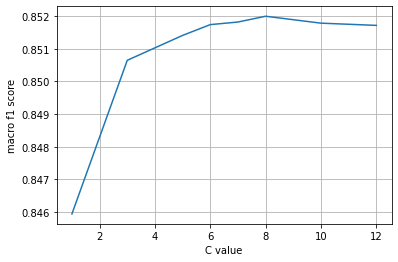

In [26]:
if flag_tuning:
    #plot C value graph - Logistic regression
    plt.grid(True)
    plt.xlabel("C value")
    plt.ylabel("macro f1 score")
    plt.plot(c_values, scores_c_value);
    plt.savefig('C_valueLogisticRegression.svg', bbox_inches="tight")

More fine tuning hyperparameter for **LinearSVC**

In [27]:
if flag_tuning:
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2]
    scores_c_value = np.zeros((len(c_values), ))
    for i in range(len(c_values)):
        c_value = c_values[i]
        model = make_pipeline(
            make_column_transformer( 
                (TfidfVectorizer(ngram_range=(1, 3), sublinear_tf = True ), "text"),
                (OneHotEncoder(handle_unknown="ignore"), ["user", "hour", "weekday", "month", "day"]),
                remainder="passthrough",
                n_jobs=-1
            ),
            LinearSVC(C = c_value, random_state=42, max_iter = 100000, tol = 0.01)
        )
        model.fit(X_train, y_train);
        scores_c_value[i] = f1_score(y_test, model.predict(X_test), average='macro')
        print(f"C value = {c_value}: {scores_c_value[i]}")

C value = 0.1: 0.8476742462424939
C value = 0.2: 0.8511630575687361
C value = 0.3: 0.8520640867131453
C value = 0.4: 0.8522751697204503
C value = 0.5: 0.8520915517047729
C value = 0.6: 0.851925726067774
C value = 0.7: 0.8519311158675982
C value = 0.8: 0.8515922420438387
C value = 0.9: 0.8513010555627882
C value = 1: 0.851175425848105
C value = 2: 0.8505968070376245


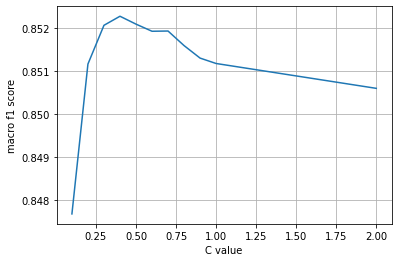

In [28]:
if flag_tuning:
    #plot C value graph - linearSVC
    plt.grid(True)
    plt.xlabel("C value")
    plt.ylabel("macro f1 score")
    plt.plot(c_values, scores_c_value);
    plt.savefig('C_valueLinearSVC.svg', bbox_inches="tight")

# Prediction and final result on eval dataset

In [35]:
eval_dataset = pd.read_csv(dir_path + "evaluation.csv",  infer_datetime_format=True, parse_dates=["date"])
print(f"Evaluation dataset size: {eval_dataset['text'].size}")

eval_dataset["hour"] = eval_dataset["date"].apply(lambda x: x.hour)
eval_dataset["weekday"] = eval_dataset["date"].apply(lambda x: x.weekday())
eval_dataset["month"] = eval_dataset["date"].apply(lambda x: x.month)
eval_dataset["day"] = eval_dataset["date"].apply(lambda x: x.day)

df_eval_done = eval_dataset.drop(columns=["flag", "ids", "date"])

df_eval_done["text"] = df_eval_done["text"].apply(lambda tweet: preprocess_text_tweet_for_tfidfVect(tweet))


/home/matteo/.local/lib/python3.8/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Evaluation dataset size: 74999


In [37]:
model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range= (1, 3), sublinear_tf = True), "text"),
                (OneHotEncoder(handle_unknown="ignore"), ["user", "hour", "weekday", "month", "day"]),
                remainder="passthrough",
                n_jobs=-1
            ),
#         LogisticRegression(C = 8, max_iter = 1000, n_jobs=-1, tol=0.001)
        LinearSVC(C = 0.4, max_iter = 100000, random_state=42, tol = 0.01)
    )
model.fit(X_train, y_train);

F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.8522751697204503


In [31]:
# evaluation of the model and write to file
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


### ROC curve

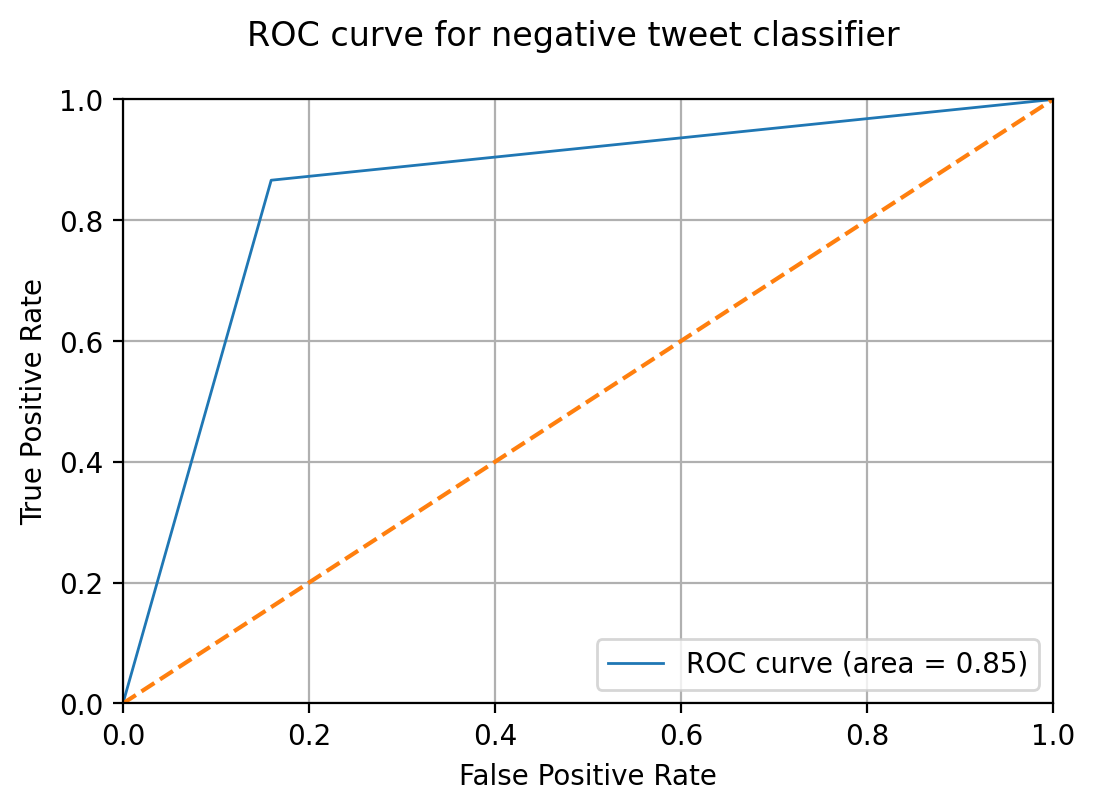

In [32]:
y_pred = model.predict(X_test) #[:,1]

# compute the false positive and true positive rate for the class 'neg'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(dpi=200)
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
fig.suptitle('ROC curve for negative tweet classifier')
ax.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed')
plt.savefig('Roc_curve.svg', bbox_inches="tight")

# Confusion matrix

[[15825  3001]
 [ 3450 22346]]




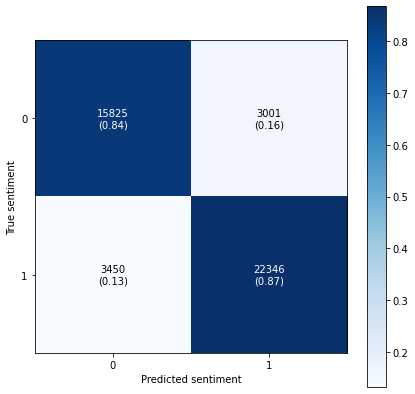

In [33]:
conf_matrix=confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,figsize=(7, 7),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
ax.set_xlabel('Predicted sentiment');ax.set_ylabel('True sentiment');
plt.savefig('ConfusionMatrix.svg', bbox_inches="tight")
plt.show()

# Correlations

**Correlation** between some column and sentiment

In [34]:
# #calculate correlation between lenght of tweet and sentiment
dev_dataset['lenght'] = dev_dataset["text"].apply(lambda tweet: len(tweet))
correlation = dev_dataset['sentiment'].corr(dev_dataset['lenght'])
correlation # -0.036

-0.039638183420255255

In [35]:
# #calculate correlation between capital letter count inside tweet and sentiment
dev_dataset['countCapital'] = dev_dataset["text"].apply(lambda tweet: len(re.findall(r'[A-Z]',tweet)))
correlation = dev_dataset['sentiment'].corr(dev_dataset['countCapital'])
correlation # 0.025

0.024509395593694545

In [36]:
#calculate correlation between hour and sentiment
correlation = df_done['sentiment'].corr(df_done['hour'])
correlation # 0.067

-0.06716264581023598

In [37]:
#calculate correlation between weekday and sentiment
correlation = df_done['sentiment'].corr(df_done['weekday'])
correlation # 0.028

0.028373686590151534

In [38]:
#calculate correlation between month and sentiment
correlation = df_done['sentiment'].corr(df_done['month'])
correlation # -0.14

-0.14652841509906894

In [40]:
#calculate correlation between day and sentiment
correlation = df_done['sentiment'].corr(df_done['day'])
correlation # -0.066

-0.06699386121255457

**Correlation** between tweet text word and sentiment. The following code will show the 20 most negative correlated and 20 most positive correlated word. The relative frequency is showed

In [16]:
from collections import Counter

frequencyWord = Counter([word for text in df_done['text'] for word in text.split()])
mostFrequentWord = pd.DataFrame(frequencyWord.most_common(5000),columns=['Word','Counts'])

# for memory size problem take only first 30000 tweet
word_corr = df_done[:30000].text.str.get_dummies(sep=' ').corrwith(df_done.sentiment/df_done.sentiment.max())

dictionary = {"Word": word_corr.index, "Correlation": word_corr.values}
corrDataframe = pd.DataFrame(dictionary)

corrDataframe.set_index('Word')
mostFrequentWord.set_index('Word')

joinedDataframe = corrDataframe.merge(mostFrequentWord)
print("Most negative correlated word to sentiment with relative frequency")
joinedDataframe.sort_values(by=['Correlation'])[:20]
# joinedDataframe["corr"].round(1)
# joinedDataframe.to_csv("frequency_corr.csv")
# joinedDataframe

Most negative correlated word to sentiment with relative frequency


,Word,Correlation,Counts
3009,not,-0.186428,47793
2162,i,-0.157089,157802
3665,sad,-0.118118,3093
3993,sorry,-0.097013,4424
2899,my,-0.096358,38746
2989,no,-0.092470,11186
1979,hate,-0.091922,2644
2809,miss,-0.090108,3902
433,bad,-0.081616,3477
4838,wish,-0.079345,3555


In [17]:
print("Most positive correlated word to sentiment with relative frequency")
joinedDataframe.sort_values(by=['Correlation'], ascending=False)[:20]

Most positive correlated word to sentiment with relative frequency


,Word,Correlation,Counts
4957,you,0.140061,66674
4316,thanks,0.113575,7747
2621,love,0.089250,9909
1855,good,0.086734,15332
4311,thank,0.086303,4083
1889,great,0.070314,4614
4907,ww,0.069370,1731
408,awesome,0.068133,2966
4963,your,0.062857,15026
160,add,0.060972,1543
